# Financial Machine Learning - EGES 3
### Assignment 2 Practical Part - Skander Chouchene
    Parts:
    I/Style factor attribution of portfolio returns
    II/The Roll’s measure (spread)
    III/Testing the EMH
    IV/High frequency stock direction prediction
    V/Execution strategies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score


# I) Style factor attribution of portfolio returns

In [2]:
factors=pd.read_csv("factors.csv",sep=None,index_col=0)
momentum=pd.read_csv("momentum.csv",sep=None,index_col=0).iloc[:-2]

<ipython-input-2-42662e525862>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  factors=pd.read_csv("factors.csv",sep=None,index_col=0)
<ipython-input-2-42662e525862>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  momentum=pd.read_csv("momentum.csv",sep=None,index_col=0).iloc[:-2]


In [3]:
portfolio_ret=pd.read_csv("daily_portef_ret.csv",index_col=0)

In [4]:
factors["Mkt"]=factors["Mkt-RF"]+factors["RF"]
factors.drop(["Mkt-RF","RF"],inplace=True,axis=1)

factors=factors.loc[20100104:20200924]
momentum=momentum.loc['20100104':'20200924']


In [5]:
def strtodateformat(ch):
    return ch[:4]+'-'+ch[4:6]+'-'+ch[6:]

In [6]:
l=factors.index.copy()
l=l.astype(str)
l=[strtodateformat(k) for k in l]
factors["l"]=l
factors.set_index("l",inplace=True)
factors.index=pd.to_datetime(factors.index, format='%Y-%m-%d', errors='ignore')


j=momentum.index.copy()
j=[strtodateformat(k) for k in j]
momentum["j"]=j
momentum.set_index("j",inplace=True)
momentum.index=pd.to_datetime(momentum.index, format='%Y-%m-%d', errors='ignore')


In [7]:
portfolio_ret=portfolio_ret.join(factors)
portfolio_ret=portfolio_ret.join(momentum)
portfolio_ret.dropna(inplace=True)

In [8]:
portfolio_ret.head()

,Portfolio,SMB,HML,RMW,CMA,Mkt,Mom
2020-09-24,4201.281095,-0.20,0.32,0.49,0.11,0.25,-0.06
2020-09-23,4483.961919,-0.63,0.19,0.26,-0.12,-2.48,0.29
2020-09-22,4984.438765,-0.45,-1.65,0.60,-0.55,1.02,1.90
2020-09-21,1907.606756,-2.58,-1.91,-0.46,-0.32,-1.08,2.90
2020-09-18,9913.841793,0.74,-0.17,-1.11,-0.46,-0.88,0.94


In [9]:
#We should scale down the returns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(portfolio_ret["Portfolio"].to_numpy().reshape(-1, 1))
portfolio_ret["Portfolio"]=scaler.transform(portfolio_ret["Portfolio"].to_numpy().reshape(-1, 1))

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test=train_test_split(portfolio_ret.drop("Portfolio",axis=1),portfolio_ret["Portfolio"],test_size=0.2)
reg=LinearRegression()
reg.fit(X_train,y_train)
pred=reg.predict(X_test)
mean_squared_error(pred,y_test)
reg.score(X_train,y_train)

0.003763634616077871

In [11]:
import statsmodels.api as sm

In [12]:
portfolio_ret.dropna(inplace=True)
X=portfolio_ret.iloc[:,1:].values
y=portfolio_ret["Portfolio"].values
size = int(len(X) * 0.8)
model = sm.OLS(y,X)
results = model.fit()
print("Summary for model")
print(results.summary())
print("\n \n")

Summary for model
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.082
Date:                Fri, 06 Nov 2020   Prob (F-statistic):                       0.370
Time:                        20:24:36   Log-Likelihood:                         -3791.0
No. Observations:                2674   AIC:                                      7594.
Df Residuals:                    2668   BIC:                                      7629.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

# II) The Roll’s measure (spread)

### 1) Importing Data

In [13]:
import os
import glob
directory=os.getcwd()+"\\DOW\\"
files = glob.glob(os.getcwd()+"\\DOW\\*.csv")

In [14]:
DOW=[]
for i in range(len(files)):
    df=pd.read_csv(files[i])
    df.Date=pd.to_datetime(df.Date, format='%Y-%m-%d', errors='ignore')
    DOW.append(df)

In [15]:
DJI=pd.read_csv("DJI.csv")

In [16]:
#DOW[0].reindex(index=DOW[0].index[::-1])

In [17]:
stock_names=["AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON","IBM","INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","V","VZ","WBA","WMT"]

### 2) 3) 4) 5) Computing Features/Target

In [18]:
#Defining Returns and SMA functions
def returns(df,n):
    ch="Returns_"+str(n)
    d=10000*np.log(df["Close"]/df.shift(n)["Close"])
    return d,ch

def SMA(df,t,n):
    return (df["Close"].iloc[t-n:t].sum())/n


def sma_change(df,n):
    
    ch=str(n)
    ch="sma_change_"+ch
    d=[np.nan for i in range(df.shape[0])]
    
    for t in range(n,df.shape[0]):
        d[t]=-1+df["Close"].iloc[t]/SMA(df,t,n)
    return d,ch

def roll():
    return 0

In [19]:
l=[]
for i in range(len(DOW)):
    k=DOW[i]
    for n in [1,2,5,10,20,60]:
        d,ch=returns(DOW[i],n)
        k[ch]=d                
        d2,ch2=sma_change(DOW[i],n)
        k[ch2]=d2
    l.append(k)
        #DOW[i].dropna(axis=0,inplace=True)
DOW=l

In [20]:
for i in range(len(DOW)):
    stock,ch=returns(DOW[i],-1)
    DOW[i]["next_return"]=stock
    DOW[i].dropna(axis=0,inplace=True)

In [21]:
DOW_df=pd.concat(DOW)

In [22]:
DOW_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns_1,sma_change_1,Returns_2,sma_change_2,Returns_5,sma_change_5,Returns_10,sma_change_10,Returns_20,sma_change_20,Returns_60,sma_change_60,next_return
60,2000-03-29,1.244420,1.244978,1.194894,1.213728,1.048830,239836800,-231.777260,-0.022911,-263.172441,-0.024445,-589.187447,-3.298931e-02,1564.528545,0.027010,422.604732,0.062816,1942.547706,0.189302,778.995499
61,2000-03-30,1.192522,1.229353,1.119978,1.122768,0.970228,414400000,-778.995499,-0.074943,-1010.772759,-0.085663,-1166.780120,-9.483538e-02,338.678302,-0.063881,302.746292,-0.018991,2044.326693,0.096336,-769.796458
62,2000-03-31,1.137835,1.225446,1.125000,1.212612,1.047865,404633600,769.796458,0.080020,-9.199041,0.037975,-209.474168,1.649332e-07,829.622287,0.007885,592.454431,0.057962,2668.851444,0.180078,185.797358
63,2000-04-03,1.209821,1.245536,1.155692,1.190290,1.028576,328563200,-185.797358,-0.018408,583.999100,0.019354,-458.168840,-1.423463e-02,805.117510,-0.018543,588.970196,0.035336,3388.192914,0.153043,460.509323
64,2000-04-04,1.184152,1.187500,1.042411,1.136719,0.982283,660329600,-460.509323,-0.045007,-646.306681,-0.053878,-887.282982,-4.981806e-02,-581.667054,-0.069778,354.775308,-0.014180,2464.871089,0.095100,-237.704289


### 5) Correlation between predictors and Y

In [23]:
from scipy.stats import pearsonr
def corr_and_pval(data):
    coeffmat = np.zeros((data.shape[1], data.shape[1]))
    pvalmat = np.zeros((data.shape[1], data.shape[1]))

    for i in range(data.shape[1]):    
        for j in range(data.shape[1]):
            corrtest = pearsonr(data[data.columns[i]], data[data.columns[j]])

            coeffmat[i,j] = corrtest[0]
            pvalmat[i,j] = corrtest[1]
    return coeffmat, pvalmat

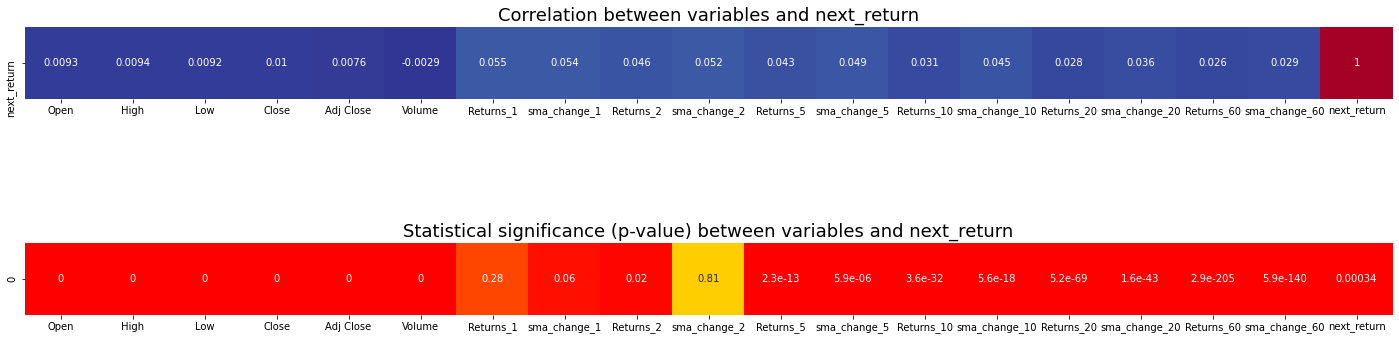

In [24]:
fig, (ax1,ax2) =plt.subplots(2,1,figsize=(30,5))
data=DOW_df.iloc[:,1:]
corr_mat=data.corr(method="pearson").loc[['next_return'],:]
#plt.figure(figsize=(20,60))
    
title="Correlation between variables and next_return"
title2="Statistical significance (p-value) between variables and next_return"
    
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='RdYlBu_r',cbar=False,ax=ax1)
ax1.set_title(title,fontdict={'fontsize': 18})
    
sns.heatmap(np.transpose(corr_and_pval(data)[1][0].reshape(corr_and_pval(data)[1][:,0].shape[0],1)),xticklabels=data.columns,vmax=1,square=True,annot=True,cmap="autumn",cbar=False,ax=ax2)
ax2.set_title(title2,fontdict={'fontsize': 18})

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=2, wspace=0.5)


### 6) Scatter plots

In [25]:
def bscatter(X,Y,k):
    Xnom, thresh=pd.qcut(X, k, retbins=True)
    tp = pd.DataFrame({'Xnom': Xnom, 'X': X, 'Y':Y})
    GMn  = tp.groupby('Xnom').mean()
    SeMn = tp.groupby('Xnom').std()/ np.sqrt(tp.groupby('Xnom').count())
    Xq = GMn.X
    Yq = GMn.Y
    XSe = SeMn.X
    YSe = SeMn.Y
    return(Xq,XSe,Yq,YSe)

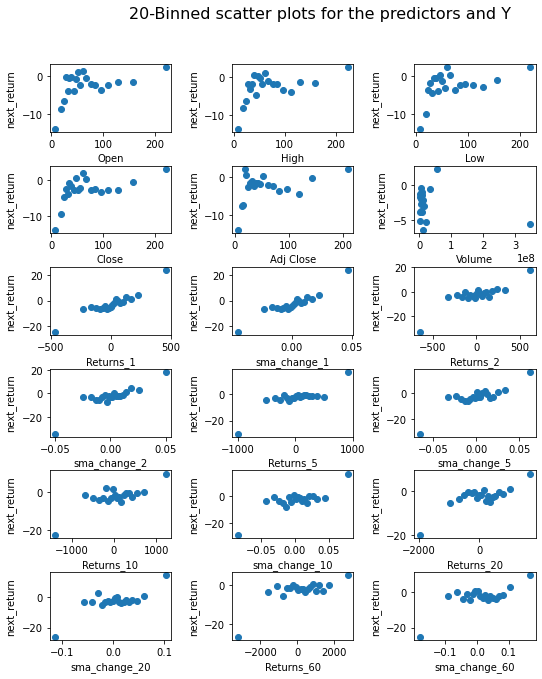

In [26]:
fig, ax = plt.subplots(figsize=(10,10),nrows=6,ncols=3)
title='20-Binned scatter plots for the predictors and Y'
fig.suptitle(title, fontsize=16)
columns=DOW_df.columns[1:-1]    
for j in range(len(columns)):
    col=columns[j]
    Xq,XSe,Yq,YSe=bscatter(DOW_df[col].values,DOW_df['next_return'].values, 20)

    ax[j//3,j%3].scatter(x=Xq,y=Yq)
    ax[j//3,j%3].set_xlabel(col)
    ax[j//3,j%3].set_ylabel("next_return")

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.show()


### 7) Binning Y

In [27]:
def sign(x):
    if x==0:
        return 0
    else:
        return int(x/abs(x))
    
for stock in DOW:
    Y=stock["next_return"]
    mean=stock["next_return"].mean()
    Y=Y-mean
    Y=Y.apply(sign)
    stock["Y"]=Y

### 8) Classification

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train,X_val,y_train,y_val=train_test_split(stock.iloc[:,6:-2],stock["Y"],test_size=0.2)

#### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

In [31]:
model=LogisticRegression()
model.fit(X_train,y_train)
pred=model.predict(X_val)
accuracy_score(pred,y_val)

0.49613899613899615

In [32]:
print(classification_report(pred,y_val))

              precision    recall  f1-score   support

          -1       1.00      0.50      0.66      1036
           1       0.00      0.00      0.00         0

    accuracy                           0.50      1036
   macro avg       0.50      0.25      0.33      1036
weighted avg       1.00      0.50      0.66      1036



C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### LDA

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [34]:
lda=LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
pred=lda.predict(X_val)
accuracy_score(pred,y_val)

0.5173745173745173

In [35]:
print(classification_report(pred,y_val))

              precision    recall  f1-score   support

          -1       0.67      0.51      0.58       676
           1       0.37      0.53      0.43       360

    accuracy                           0.52      1036
   macro avg       0.52      0.52      0.51      1036
weighted avg       0.57      0.52      0.53      1036



#  III) Testing the EMH

### Normality (using Jarque-Bera)

In [36]:
from statsmodels.stats.stattools import jarque_bera

l=[jarque_bera(stock["next_return"]) for stock in DOW]
normality=pd.DataFrame(l,index=stock_names,columns=["JB","p_value","skewness","kurtosis"]).transpose()

In [37]:
normality

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
JB,3.055620e+06,7420.590930,28938.275269,71100.056936,5077.269883,9397.591494,19052.752577,117215.321569,21377.727154,1794.974330,...,184036.650616,22720.834594,23114.629699,21134.605358,91681.072407,89682.806282,10816.022199,9067.667271,14486.398620,12693.334543
p_value,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
skewness,4.327240e+00,-0.249259,-0.024566,0.560530,0.199767,-0.343909,-0.078187,0.589185,0.197047,1.140002,...,1.457098,0.170416,0.183550,0.128678,0.316614,-0.100524,0.122142,-0.051283,0.354413,-0.236382
kurtosis,1.216693e+02,8.842311,14.579056,21.115307,7.833674,10.423379,12.394192,26.274321,12.944449,13.890038,...,32.054895,13.254468,13.342149,12.892154,23.600393,23.383287,12.122531,9.480883,11.161863,10.654235


#### The returns do not follow a normal distribution

### Autocorrelation test (Ljung-Box Test)

In [38]:
from statsmodels.tsa.stattools import acf
l=[acf(stock["next_return"],qstat=True)[2] for stock in DOW]
l[0]

C:\Users\ALEX\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([3.37981423e-03, 1.35177876e-02, 2.93843712e-02, 9.82097747e-04,
       7.64214722e-04, 8.98316440e-04, 2.93165901e-04, 2.51584293e-04,
       4.91921529e-04, 1.67068283e-04, 3.12497615e-04, 3.60036590e-05,
       1.80034044e-05, 7.04329107e-06, 5.00745109e-06, 7.53583197e-06,
       2.07610376e-07, 4.16462167e-07, 7.69836596e-07, 1.46141411e-06,
       9.00839059e-07, 8.46224930e-07, 4.55126854e-07, 5.48277381e-07,
       9.77220807e-07, 1.26077542e-06, 2.11000767e-06, 2.78901488e-06,
       4.71616483e-06, 4.68081789e-06, 7.46189425e-06, 1.17757024e-05,
       1.46629637e-05, 1.85165863e-05, 2.90206587e-05, 4.13559744e-05,
       4.70248315e-05, 7.11609800e-05, 4.74280721e-05, 6.15232838e-05])

#### For all the DOW components, the p_values for the Ljung-Box statistical test are significantly small. Therefore we reject the test's null hypothesis (which states that the data is independently distributed).
#### => The data is autocorrelated

### DOW index

In [39]:
ret_dji=returns(DJI,-1)[0]
ret_dji=pd.DataFrame(ret_dji).dropna()
jarque_bera(ret_dji)

(array([39770.12823739]),
 array([0.]),
 array([0.38316438]),
 array([16.81190102]))

#### The DOW does not follow a normal distribution

In [41]:
acf(ret_dji,qstat=True)[2]

C:\Users\ALEX\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([1.67432748e-17, 5.73034520e-17, 9.32405183e-17, 6.40863749e-17,
       1.75575948e-16, 8.07740698e-18, 6.93690703e-20, 6.54773001e-20,
       2.71756486e-21, 9.06422490e-21, 2.12656786e-20, 1.09673168e-21,
       3.95219979e-22, 9.21974956e-22, 4.15099102e-26, 7.22370315e-32,
       1.24161310e-31, 2.34444444e-33, 8.02105313e-33, 2.63271720e-32,
       5.04757292e-32, 1.24496379e-31, 3.40290976e-31, 9.72719367e-31,
       2.15959791e-30, 3.59839879e-30, 1.54537338e-30, 3.48658100e-30,
       5.95253649e-30, 1.26890163e-29, 1.76059809e-29, 4.16480330e-29,
       9.48142683e-29, 3.16601622e-31, 7.81968799e-31, 6.01201253e-31,
       1.55133744e-30, 3.66334266e-30, 3.50756609e-30, 8.44597711e-30])

#### For the DOW index, the p_values for the Ljung-Box statistical test are significantly small. Therefore we reject the test's null hypothesis.
#### => The DOW is autocorrelated

### Conclusion (Market Efficiency):
#### The DOW components as well as all the DOW itself are autocorrelated. This means that the market is not efficient.

# IV) High frequency stock direction prediction

In [54]:
tick_data = pd.read_csv('IVE_tickbidask.txt', sep=",", header=None)
tick_data.columns = ["Date","Time","Price","Bid","Ask","Size"]

In [55]:
tick_data["Datetime"]=tick_data["Date"]+" "+tick_data["Time"]
tick_data.drop(["Date","Time"],axis=1,inplace=True)
tick_data.Datetime=pd.to_datetime(tick_data.Datetime,  format='%m/%d/%Y %H:%M:%S', errors='ignore')
#tick_data.Datetime=pd.to_datetime(tick_data.Datetime).dt.strftime('%d/%m/%Y %H:%M:%S')
tick_data.set_index("Datetime",inplace=True)

### 2) Tick rule

In [56]:
def tick_direction(df):
    tick_dir=[]
    for i in range(1,df.shape[0]):
        pi=df["Price"].iloc[i]
        j=i-1
        pj=df["Price"].iloc[j]
        
        while pi==pj:
            j-=1
            pj=df["Price"].iloc[j]
        
        if pi>pj:
            tick="Buy"
        if pi<pj:
            tick="Sell"
        
        tick_dir.append(tick)
    
    return tick_dir



In [57]:
tick_dir=tick_direction(tick_data)
tick_dir.insert(0,np.nan)

tick_data["TickDirection"]= tick_dir

### 3) Lee Ready algorithm

In [58]:
def sign_to_trade(x):
    if x[0]==1.0:
        return "Buy"
    elif x[0]==-1.0:
        return "Sell"


mid=0.5*tick_data["Bid"]+0.5*tick_data["Ask"]

diff=(tick_data["Price"]-mid)
diff=pd.DataFrame(diff/abs(diff),index=diff.index,columns=["sign"])
tick_data["LRDirection"]=diff.apply(lambda x: sign_to_trade(x),axis=1)


In [59]:
tick_data.dropna(inplace=True)

### 4) One-minute data summary

In [60]:
data_summary=tick_data.resample("T").first()

data_summary.head()

,Price,Bid,Ask,Size,TickDirection,LRDirection
Datetime,,,,,,
2009-09-28 09:30:00,50.71,50.70,50.79,638.0,Sell,Sell
2009-09-28 09:31:00,50.75,50.75,50.76,100.0,Buy,Sell
2009-09-28 09:32:00,50.78,50.76,50.78,300.0,Buy,Buy
2009-09-28 09:33:00,50.81,50.80,50.81,500.0,Sell,Buy
2009-09-28 09:34:00,50.82,50.80,50.82,100.0,Buy,Buy


In [61]:
data_summary.drop(data_summary.index[:5],inplace=True)
data_summary.drop(data_summary.index[data_summary.shape[0]-5:],inplace=True)

#### VWAP and quantities

In [62]:
qty=tick_data.resample("T").sum()["Size"]
qty_x_price=tick_data["Price"]*tick_data["Size"]
qty_x_price=qty_x_price.resample("T").sum()

VWAP=qty_x_price/qty

data_summary["VWAP"]=VWAP

In [63]:
#Quantity over 1 min
quantity=tick_data.resample("T").sum()

#Buy share TickDirection over 1 min
buffer=pd.DataFrame(tick_data["TickDirection"])
buffer=buffer[buffer['TickDirection']=="Buy"]
total_buy_Tick=buffer.resample("T").count()
data_summary["total_buy_TD"]=total_buy_Tick

#Sell share TickDirection over 1 min
buffer=pd.DataFrame(tick_data["TickDirection"])
buffer=buffer[buffer['TickDirection']=="Sell"]
total_sell_Tick=buffer.resample("T").count()
data_summary["total_sell_TD"]=total_sell_Tick

#Buy share LDR over 1 min
buffer=pd.DataFrame(tick_data["LRDirection"])
buffer=buffer[buffer['LRDirection']=="Buy"]
total_buy_LRD=buffer.resample("T").count()
data_summary["total_buy_LRD"]=total_buy_LRD

#Sell share LDR over 1 min
buffer=pd.DataFrame(tick_data["LRDirection"])
buffer=buffer[buffer['LRDirection']=="Sell"]
total_sell_LRD=buffer.resample("T").count()
data_summary["total_sell_LRD"]=total_sell_LRD


### 5) Computing features and applying models

In [64]:
#data_summary.dropna(inplace=True)
data_summary["5min_ret"]=10000*np.log(data_summary["Price"]/data_summary.shift(-5)["Price"])
#data_summary.dropna(inplace=True)
data_summary["5min_ret_sign"]=(data_summary["5min_ret"]/abs(data_summary["5min_ret"]))

In [65]:
def returns2(df,n):
    ch="Returns_"+str(n)
    d=10000*np.log(df["Price"]/df.shift(n)["Price"])
    return d,ch
for n in [5,15,20,30]:
    d,ch=returns2(data_summary,n)
    data_summary[ch]=d
#data_summary.dropna(inplace=True)

In [66]:
d,ch=returns2(data_summary,1)
data_summary[ch]=d

for n in [5,15,20,30]:
    ch="Returns_"+str(n)
    chstd="Std_ret_"+str(n)
    freq=str(n)+"T"
    m=data_summary["Returns_1"].resample(freq).mean().tolist()
    m=[q for q in m for i in range(n)]
    m=m[:len(data_summary)]
    std=(data_summary["Returns_1"]-m)**2
    std=std.resample(freq).mean()
    #data_summary[chstd]=np.sqrt(std)


In [67]:
data_summary["TickImbalance"]=(data_summary["total_buy_TD"]-data_summary["total_sell_TD"])/(data_summary["total_buy_TD"]+data_summary["total_sell_TD"])

data_summary["LRImbalance"]=(data_summary["total_buy_LRD"]-data_summary["total_sell_LRD"])/(data_summary["total_buy_LRD"]+data_summary["total_sell_LRD"])

In [68]:
under_sample=data_summary.resample("5t").first()

In [69]:
under_sample.dropna(inplace=True)

In [70]:
under_sample.head()

,Price,Bid,Ask,Size,TickDirection,LRDirection,VWAP,total_buy_TD,total_sell_TD,total_buy_LRD,total_sell_LRD,5min_ret,5min_ret_sign,Returns_5,Returns_15,Returns_20,Returns_30,Returns_1,TickImbalance,LRImbalance
Datetime,,,,,,,,,,,,,,,,,,,,
2009-09-28 10:05:00,51.210,51.21,51.23,100.0,Sell,Sell,51.210000,0.0,4,1,3.0,-13.659871,-1.0,11.723331,21.738119,41.091928,79.550550,-9.758955,-1.000000,-0.500000
2009-09-28 10:10:00,51.280,51.27,51.28,100.0,Buy,Buy,51.289841,9.0,0,9,0.0,5.851946,1.0,13.659871,27.338427,35.397990,92.076270,1.950268,1.000000,1.000000
2009-09-28 10:15:00,51.250,51.24,51.25,100.0,Buy,Buy,51.250000,2.0,0,2,0.0,8.198482,1.0,-5.851946,19.531256,21.486482,48.899853,-1.951029,1.000000,1.000000
2009-09-28 10:20:00,51.208,51.20,51.21,200.0,Sell,Buy,51.224667,14.0,7,17,4.0,-8.198482,-1.0,-8.198482,-0.390556,11.332774,21.347563,-2.343109,0.333333,0.619048
2009-09-28 10:25:00,51.250,51.23,51.25,100.0,Buy,Buy,51.250000,4.0,0,4,0.0,-1.951029,-1.0,8.198482,-5.851946,7.807925,21.486482,-1.951029,1.000000,1.000000


In [80]:
to_drop=["Price","Bid","Ask","Size","5min_ret","5min_ret_sign"]
y=under_sample["5min_ret_sign"]
X=under_sample.drop(to_drop,axis=1)

In [81]:
from sklearn.preprocessing import LabelEncoder

In [82]:
le = LabelEncoder()
le.fit(X["TickDirection"].tolist())
X["TickDirection"]=le.transform(X["TickDirection"])

le.fit(X["LRDirection"])
X["LRDirection"]=le.transform(X["LRDirection"])


In [83]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)

#### Logistic Regression

In [2]:
model=LogisticRegression()
model.fit(X_train,y_train)
pred=model.predict(X_val)
print("The validation accuracy is:", accuracy_score(pred,y_val))


The validation accuracy is: 0.5584239130434783


#### Gaussian Naive-Bayes

In [85]:
from sklearn.naive_bayes import GaussianNB

In [3]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
pred=gnb.predict(X_val)
print("The validation accuracy is:", accuracy_score(pred,y_val))


The validation accuracy is: 0.4917346014492754


# 5) Execution Strategies

In [42]:
xyz=pd.read_excel("xyz_transactions.xlsx")
xyz.head()

,Time,Trade Size (|qt|),Price (pt)
0,09:30:02,500,2.99
1,09:30:02,500,2.99
2,09:32:28,2400,3.03
3,09:33:35,100,3.03
4,09:33:38,100,3.02


### Decision Price

In [43]:
#10'o clock is at index 88
decision_price=xyz.iloc[88]
decision_price=decision_price.iloc[2]
decision_price

3.05

### 20% POV

In [44]:
freq=int(xyz.shape[0]/20)
prices=[xyz["Price (pt)"].iloc[freq*i-1] for i in range(1,21)]
pov20_avg_price=sum(prices)/len(prices)
pov20_avg_price

3.0600000000000005

### 10% POV

In [45]:
freq=int(xyz.shape[0]/10)
prices=[xyz["Price (pt)"].iloc[freq*i-1] for i in range(1,11)]
pov10_avg_price=sum(prices)/len(prices)
pov10_avg_price

3.0550000000000006

### 5% POV

In [46]:
freq=int(xyz.shape[0]/5)
prices=[xyz["Price (pt)"].iloc[freq*i-1] for i in range(1,6)]
pov5_avg_price=sum(prices)/len(prices)
pov5_avg_price

3.054

### VWAP to the close

In [47]:
VWAP=sum(xyz["Trade Size (|qt|)"].iloc[88:]*xyz["Price (pt)"].iloc[88:])/xyz["Trade Size (|qt|)"].iloc[88:].sum()

In [48]:
VWAP

3.054371583874377

### TWAP (every 5 min)

In [49]:
xyz.Time=pd.to_datetime(xyz.Time, format='%H:%M:%S', errors='ignore')
xyz=xyz.set_index("Time")

In [50]:
every_5_min=xyz.resample("5T").first()
every_5_min.head()

,Trade Size (|qt|),Price (pt)
Time,,
1900-01-01 09:30:00,500,2.99
1900-01-01 09:35:00,400,3.02
1900-01-01 09:40:00,100,3.01
1900-01-01 09:45:00,100,3.04
1900-01-01 09:50:00,100,3.04


In [51]:
TWAP=every_5_min.mean()["Price (pt)"]

In [52]:
TWAP

3.0623128205128225

In [53]:
price_comparison=pd.DataFrame([[decision_price,pov20_avg_price,pov10_avg_price,pov5_avg_price,VWAP,TWAP]],columns=["Decision Price","20% POV","10% POV","5% POV","VWAP","TWAP"],index=["Price"])
price_comparison

,Decision Price,20% POV,10% POV,5% POV,VWAP,TWAP
Price,3.05,3.06,3.055,3.054,3.054372,3.062313


#### The strategy to go with is the 5% POV, it's the closest to the decision price.